<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
!pip install gdown -q

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=a9eb1fa2-f0e1-43e6-946e-ea26b666f4a4
To: c:\Users\User\Documents\github\devtools\AI26_HSE_ML_HW\HW6\Data.zip
100%|██████████| 289M/289M [00:30<00:00, 9.59MB/s] 


'Data.zip'

In [2]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [2]:
import pandas as pd

# Слишком длинный путь 
base_dir = "Data\ДЗ по Uplift обновленное\\"
file_paths = {
    "aggs": "AGGS_FINAL.csv",
    "campaigns": "CAMPAINGS.csv",
    "contracts": "CONTRACTS_FINAL.csv",
    "people": "PEOPLE_IN_CAMPAINGS_FINAL.csv"
}
aggs = pd.read_csv(base_dir + file_paths["aggs"], index_col=0)
campaigns = pd.read_csv(base_dir + file_paths["campaigns"], index_col=0)
contracts = pd.read_csv(base_dir + file_paths["contracts"], index_col=0)
people = pd.read_csv(base_dir + file_paths["people"], index_col=0)
aggs["report_dt"] = pd.to_datetime(aggs["report_dt"])
contracts["contract_date"] = pd.to_datetime(contracts["contract_date"])
people["delivery_date"] = pd.to_datetime(people["delivery_date"].replace("unknown", ""))

In [3]:
nov_campaigns = people[
    (people['delivery_date'].dt.to_period('M') == '2024-11') &
    (people['campaing_id'].isin(campaigns['campaing_id']))
]['campaing_id'].unique()

people_nov = people[people['campaing_id'].isin(nov_campaigns)]
user_campaign_count = people_nov.groupby('user_id')['campaing_id'].nunique()
valid_users = user_campaign_count[user_campaign_count == 1].index
people_nov = people_nov[people_nov['user_id'].isin(valid_users)]

people_nov = people_nov.merge(
    campaigns[['campaing_id', 'channel']], 
    on='campaing_id'
)
aggs_nov = aggs[aggs['report_dt'] == '2024-11-30']
data = people_nov.merge(aggs_nov, on='user_id')

In [4]:
def get_purchase_flag(row: pd.Series) -> bool:
    
    user_contracts = contracts.loc[contracts['user_id'] == row['user_id']]

    if row['t_flag'] == 1:
        start_date = row['delivery_date']
        if pd.isna(start_date):  
            return False
        end_date = start_date + pd.Timedelta(days=14)  # 2 weeks
    else:
        start_date = pd.Timestamp('2024-11-01')
        end_date = start_date + pd.Timedelta(days=21)  # 3 weeks
    purchases_in_window = user_contracts[
        (user_contracts['contract_date'] >= start_date) &
        (user_contracts['contract_date'] <= end_date)
    ]
    return not purchases_in_window.empty  

In [5]:
data['purchased'] = data.apply(get_purchase_flag, axis=1)

In [6]:
data

,campaing_id,user_id,t_flag,delivery_date,channel,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,age,city,purchased
0,idclip,1099975,1,2024-11-06,sms,-2.947076,1.304330,-2.432121,2.607666,1.115625,1.029585,-2.140406,1.009034,3.804885,2024-11-30,42,Moscow,True
1,idclip,1106346,1,2024-11-05,sms,1.204456,0.443725,0.523118,1.420845,0.103217,1.301411,-2.184509,-1.037429,-2.088870,2024-11-30,32,Moscow,False
2,idclip,1157443,1,2024-11-07,sms,0.124863,1.478867,0.554146,1.393648,1.780764,0.242856,-0.188883,-0.673373,-0.699805,2024-11-30,33,Ufa,False
3,idclip,1063142,1,2024-11-06,sms,1.540270,0.017949,-0.124650,2.326580,2.065172,-0.641982,-1.895822,0.578831,-1.043826,2024-11-30,40,Ufa,False
4,idclip,1054501,1,2024-11-07,sms,3.413699,0.268051,0.595458,-0.724793,0.672260,0.062259,-0.881019,-1.225385,-4.455658,2024-11-30,22,Moscow,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,idkfa,2113479,0,NaT,other_ads,1.090394,-0.612114,-0.245097,1.703135,4.185669,-0.351331,-2.082389,0.193862,-0.923349,2024-11-30,21,Smolensk,False
399996,idkfa,2116899,1,2024-11-08,other_ads,-0.245355,1.490551,1.365133,2.817186,0.330343,-0.640073,0.505516,2.112013,2.048839,2024-11-30,30,Moscow,True
399997,idkfa,2052080,1,2024-11-07,other_ads,1.281616,2.151506,1.685434,-0.474584,0.639100,1.666082,-2.331053,0.506082,-0.847655,2024-11-30,36,Ufa,False
399998,idkfa,2046148,1,2024-11-06,other_ads,-0.939702,-0.598843,1.557447,2.966751,0.128229,1.037924,-0.882491,1.574892,2.283507,2024-11-30,43,Ufa,True


In [7]:
data["t_flag"].value_counts()

t_flag
1    200000
0    200000
Name: count, dtype: int64

In [8]:
pd.DataFrame((data.groupby(["t_flag", "channel"])["purchased"].mean() * 100).round(2))

purchased
t_flag channel             
0      banner         40.07
       other_ads      40.07
       push           20.22
1      banner         60.27
       other_ads      60.27
       push           60.86
       sms            20.12

<Figure size 1000x600 with 0 Axes>

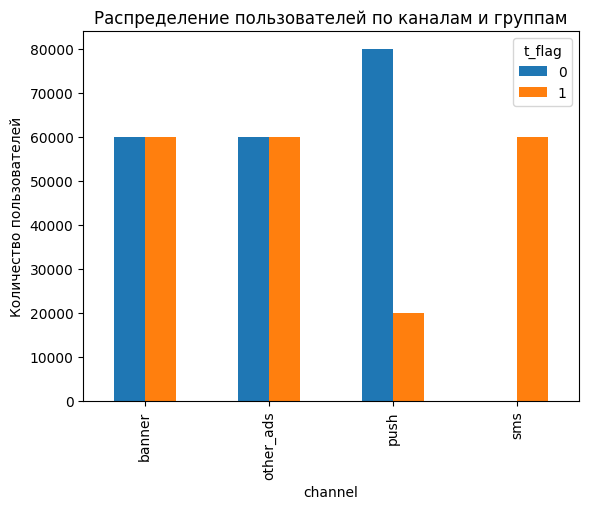

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
people_nov.groupby(['channel', 't_flag']).size().unstack().plot(kind='bar')
plt.title('Распределение пользователей по каналам и группам')
plt.ylabel('Количество пользователей')
plt.show()

### ваши выводы здесь

- Размеры обеих групп (целевой и контрольной) являются статистически значимыми, что позволяет проводить дальнейший анализ и делать достоверные выводы.
- Все используемые каналы коммуникации имеют статистически значимые размеры
- Каждый пользователь участвует только в одной кампании, что исключает влияние повторных взаимодействий на результаты анализа
- Для всех пользователей из целевой группы указана дата коммуникации, что обеспечивает полноту данных
- оммуникации равномерно распределены по дням, что исключает возможность перекоса
- Канал sms был только в 1 группе, что странно и стоило бы дополнительно спросить у кого-то почему так елси бы мы были в реальной жизни)
- Странно что у баннеров и other_ads одна эффективность мб нейминг каналов поплыл)


In [10]:
control_group = data[data["t_flag"] == 0].groupby("channel")["purchased"].mean()
treatment_group = data[data["t_flag"] == 1].groupby("channel")["purchased"].mean()
print("Control Rates:")
print(control_group)
print("\nTreatment  Rates:")
print(treatment_group)
print("\n==== Uplift ====")
uplift = ((treatment_group - control_group) * 100).round(2)
print(uplift)

Control Rates:
channel
banner       0.400733
other_ads    0.400733
push         0.202150
Name: purchased, dtype: float64

Treatment  Rates:
channel
banner       0.602717
other_ads    0.602717
push         0.608550
sms          0.201167
Name: purchased, dtype: float64

==== Uplift ====
channel
banner       20.20
other_ads    20.20
push         40.64
sms            NaN
Name: purchased, dtype: float64


<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [11]:
(data_2 := data[['campaing_id','user_id','t_flag','delivery_date','channel','report_dt', 'purchased']])

,campaing_id,user_id,t_flag,delivery_date,channel,report_dt,purchased
0,idclip,1099975,1,2024-11-06,sms,2024-11-30,True
1,idclip,1106346,1,2024-11-05,sms,2024-11-30,False
2,idclip,1157443,1,2024-11-07,sms,2024-11-30,False
3,idclip,1063142,1,2024-11-06,sms,2024-11-30,False
4,idclip,1054501,1,2024-11-07,sms,2024-11-30,False
...,...,...,...,...,...,...,...
399995,idkfa,2113479,0,NaT,other_ads,2024-11-30,False
399996,idkfa,2116899,1,2024-11-08,other_ads,2024-11-30,True
399997,idkfa,2052080,1,2024-11-07,other_ads,2024-11-30,False
399998,idkfa,2046148,1,2024-11-06,other_ads,2024-11-30,True


In [12]:
data_2['report_m'] = data_2['report_dt'].dt.to_period('M') - 2

C:\Users\User\AppData\Local\Temp\ipykernel_8536\3092824580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['report_m'] = data_2['report_dt'].dt.to_period('M') - 2


In [13]:
aggs['report_m'] = aggs['report_dt'].dt.to_period('M')
(data_3 := data_2.merge(aggs, how='left', on=['user_id', 'report_m']))
data_3['city'] = pd.factorize(data_3['city'], sort=True)[0] + 1

In [14]:
data_3.isna().sum()

campaing_id           0
user_id               0
t_flag                0
delivery_date    200000
channel               0
report_dt_x           0
purchased             0
report_m              0
x1                    0
x2                    0
x3                    0
x4                    0
x5                    0
x6                    0
x7                    0
x8                    0
x9                    0
report_dt_y           0
age                   0
city                  0
dtype: int64

In [15]:
(df_temp := data_3.drop(columns=['delivery_date', 'channel', 'report_dt_x', 'report_m', 'report_dt_y', 'purchased']))
df_temp.groupby(['campaing_id', 't_flag']).mean()

user_id        x1        x2        x3        x4  \
campaing_id t_flag                                                         
idclip      1       1.079941e+06  0.613410  1.001479  0.996336 -0.606077   
iddqd       0       8.003378e+04  0.604476  0.991262  0.989826 -0.606210   
            1       8.004467e+04  0.567231  1.013764  0.999262 -0.569823   
iddt        0       4.059840e+06 -0.200788 -1.005438  0.195224 -0.201540   
            1       4.060159e+06 -0.190153 -0.996064  0.201646 -0.199495   
idkfa       0       2.060079e+06 -0.200788 -1.005438  0.195224 -0.201540   
            1       2.059920e+06 -0.190153 -0.996064  0.201646 -0.199495   

                          x5        x6        x7        x8        x9  \
campaing_id t_flag                                                     
idclip      1       0.607142 -0.003577 -0.003194 -0.002058  0.532910   
iddqd       0       0.592924 -0.002248 -0.002248 -0.000358  0.524898   
            1       0.578837  0.000178 -0.010200 -0.001318  0.498965   
iddt        0       0.005851 -0.000878  0.335597  0.333879 -0.231895   
            1      -0.003222  0.002184  0.335707  0.332511 -0.234196   
idkfa       0       0.000000 -0.000878  0.335597  0.333879 -0.231895   
            1      -0.003222  0.002184  0.335707  0.332511 -0.234196   

                          age      city  
campaing_id t_flag                       
idclip      1       32.538800  2.002517  
iddqd       0       32.504013  2.002625  
            1       32.415350  2.002200  
iddt        0       32.531317  2.000933  
            1       32.500350  2.004450  
idkfa       0       32.565050  1.997967  
            1       32.494200  2.005933

In [16]:
df_temp.groupby(['campaing_id', 't_flag']).median()

user_id        x1        x2        x3        x4  \
campaing_id t_flag                                                      
idclip      1       1079869.5  0.688788  0.996818  0.998904 -0.689447   
iddqd       0         80012.5  0.690167  0.991941  0.991280 -0.698398   
            1         80423.5  0.653599  1.010234  0.993041 -0.659436   
iddt        0       4059814.0 -0.039344 -1.000710  0.151140 -0.191527   
            1       4060191.5 -0.029260 -0.992088  0.163890 -0.182136   
idkfa       0       2059939.5 -0.039344 -1.000710  0.151140 -0.191527   
            1       2060077.0 -0.029260 -0.992088  0.163890 -0.182136   

                          x5        x6        x7        x8        x9   age  \
campaing_id t_flag                                                           
idclip      1       0.724927 -0.008930 -0.188274 -0.510997  0.583088  33.0   
iddqd       0       0.715804  0.000645 -0.208016 -0.561839  0.575092  32.0   
            1       0.698363 -0.001471 -0.215969 -0.560481  0.549919  32.0   
iddt        0       0.004826  0.001446  0.520809  0.712336 -0.245529  33.0   
            1      -0.004370  0.006098  0.513940  0.719739 -0.246031  33.0   
idkfa       0       0.000000  0.001446  0.520809  0.712336 -0.245529  33.0   
            1      -0.004370  0.006098  0.513940  0.719739 -0.246031  32.0   

                    city  
campaing_id t_flag        
idclip      1        2.0  
iddqd       0        2.0  
            1        2.0  
iddt        0        2.0  
            1        2.0  
idkfa       0        2.0  
            1        2.0

In [17]:
(df_temp := data_3.drop(columns=['user_id', 'delivery_date', 'channel', 'report_dt_x', 'report_m', 'report_dt_y', 'purchased']))

,campaing_id,t_flag,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,idclip,1,0.822461,1.233201,-1.000185,2.585873,-0.584520,-0.268274,-0.727814,1.606372,1.814158,42,1
1,idclip,1,-1.902137,0.322546,2.759591,-0.705195,-1.900151,0.205020,-0.647572,1.405190,-1.614184,32,1
2,idclip,1,2.696257,2.110511,1.128136,-1.827549,1.843106,0.628430,-1.736374,1.470135,1.966752,33,3
3,idclip,1,0.012609,3.115029,0.302278,1.037409,1.621966,0.177663,-1.307445,-1.234162,0.309900,40,3
4,idclip,1,-0.384869,0.356545,-1.443961,1.860932,1.054721,-1.366964,-1.481803,-0.831508,0.299337,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,idkfa,0,0.192611,-2.539540,-0.278562,-0.491431,0.000000,-0.161891,1.028837,1.110961,-0.403948,21,2
399996,idkfa,1,-0.681807,0.367606,2.433372,-1.168884,-0.449595,-1.376429,-0.839565,-1.483183,-0.442487,30,1
399997,idkfa,1,-3.110953,-2.103578,1.327757,2.637593,0.374258,-0.133801,1.238193,0.767082,-1.068198,36,3
399998,idkfa,1,1.284552,-0.501500,-1.335027,0.754281,-1.614827,-0.975406,1.936397,1.443528,-0.476519,43,3


In [18]:
# Не своровал а вдохновился
import numpy as np
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [19]:
# Iterate over each unique campaign in the dataframe
for campaign in df_temp['campaing_id'].unique():
    campaign_data = df_temp[df_temp['campaing_id'] == campaign].drop(columns=['campaing_id'])
    
    for feature in campaign_data.columns:

        control_group = campaign_data[campaign_data['t_flag'] == 0][feature]
        treatment_group = campaign_data[campaign_data['t_flag'] == 1][feature]
        
        # Calculate PSI
        psi = calculate_psi(expected=control_group, actual=treatment_group)
        
     
        if psi >= 0.1:
            print(f'Campaign {campaign}: PSI for {feature} = {psi:.4f}')

C:\Users\User\AppData\Local\Temp\ipykernel_8536\2989022567.py:47: RuntimeWarning: invalid value encountered in divide
  expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
C:\Users\User\AppData\Local\Temp\ipykernel_8536\2989022567.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  input /= np.max(input) / (max - min)


Campaign iddqd: PSI for t_flag = 9.2094
Campaign iddt: PSI for t_flag = 9.2094


C:\Users\User\AppData\Local\Temp\ipykernel_8536\2989022567.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  input /= np.max(input) / (max - min)
C:\Users\User\AppData\Local\Temp\ipykernel_8536\2989022567.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  input /= np.max(input) / (max - min)


Campaign idkfa: PSI for t_flag = 9.2094
Campaign idkfa: PSI for x5 = 9.2094
Campaign idkfa: PSI for city = 0.2949


### ваши выводы здесь


Общая оценка разбивки на группы:
Во всех кампаниях разбивка на целевую и контрольную группы выполнена корректно, за исключением одной кампании.

Проблемы с кампанией idkfa:

Признак x5:
В контрольной группе наблюдаются исключительно нулевые значения, что делает этот признак непригодным для анализа. В будущем его придется исключить из рассмотрения.

Признак city:
Кагортизация по городу (city) имеет статистически значимые различия между целевой и контрольной группами (выявлено с помощью PSI). Этот признак также потребует исключения.

Рекомендации по кампании idkfa (other_ads):
Несмотря на проблемы с признаками x5 и city, полностью исключать кампанию idkfa нецелесообразно, так как она представляет ценность для анализа большего числа каналов (помимо двух основных).

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [20]:
!pip install scikit-learn==1.4.0

In [23]:
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, TwoModels, ClassTransformation, ClassTransformationReg
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
def basic_solomodel(data, channel):
    """
    Trains a logistic regression model to calculate uplift for a specific channel and evaluates it using Qini score.

    Args:
        data (pd.DataFrame): The dataset containing user interactions and features.
        channel (str): The channel to analyze.

    Returns:
        None (displays uplift histogram and Qini curve).
    """
    # Filter data for the specified channel and drop unnecessary columns
    columns_to_drop = [
        'user_id', 'campaing_id', 'delivery_date', 'channel', 
        'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city'
    ]
    df_uplift = data[data['channel'] == channel].drop(columns=columns_to_drop)


    train_index, test_index = train_test_split(df_uplift.index, test_size=0.25, random_state=1337)
    

    X_train = df_uplift.loc[train_index].drop(columns=['purchased'])
    y_train = df_uplift.loc[train_index]['purchased']
    X_test = df_uplift.loc[test_index].drop(columns=['purchased'])
    y_test = df_uplift.loc[test_index]['purchased']
    model = LogisticRegression(random_state=1337)
    model.fit(X_train, y_train)
    X_test_0 = X_test.copy()
    X_test_0['t_flag'] = 0
    X_test_1 = X_test.copy()
    X_test_1['t_flag'] = 1
    y_pred_0 = model.predict_proba(X_test_0)[:, 1]
    y_pred_1 = model.predict_proba(X_test_1)[:, 1]
    uplift = y_pred_1 - y_pred_0
    uplift_pd = pd.DataFrame(uplift, index=X_test.index, columns=['uplift'])
    uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data=uplift_pd, x='uplift').set_title('Uplift Distribution')
    plt.show()
    qini_score = qini_auc_score(
        y_true=y_test,
        uplift=pd.Series(uplift, index=X_test.index),
        treatment=X_test['t_flag']
    )
    fig = plot_qini_curve(
        y_true=y_test,
        uplift=pd.Series(uplift, index=X_test.index),
        treatment=X_test['t_flag']
    )
    fig.figure_.set_size_inches(6, 3)
    plt.show()
    print(f'Qini Score = {qini_score:.4f}')

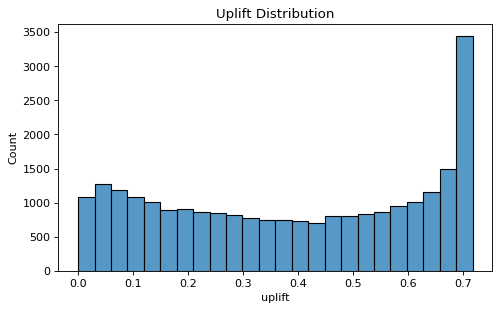

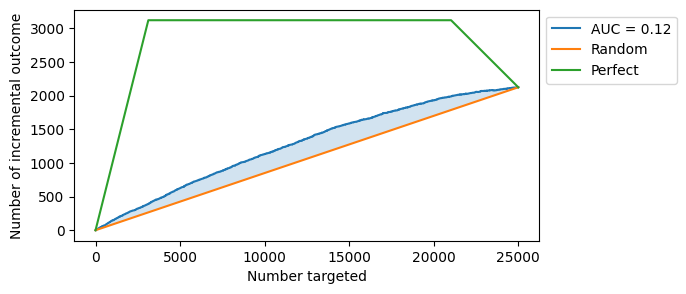

Qini Score = 0.1193


In [24]:
basic_solomodel(data_3, 'push')


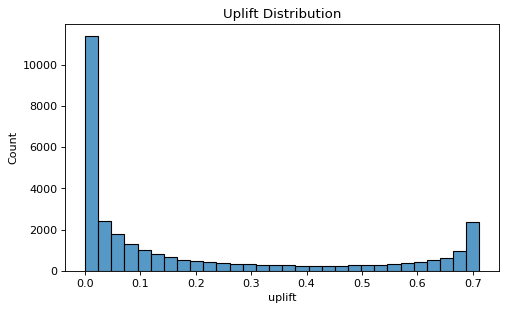

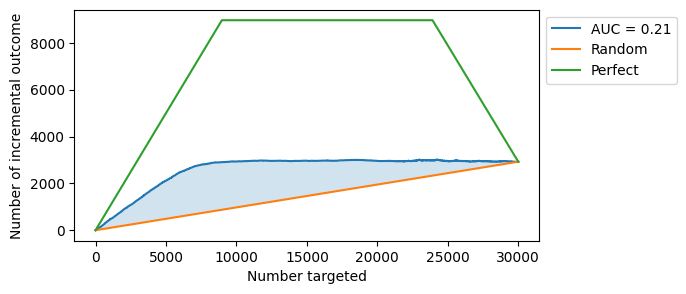

Qini Score = 0.2059


In [25]:
basic_solomodel(data_3, 'banner')

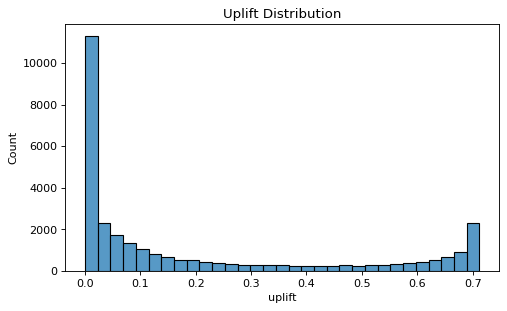

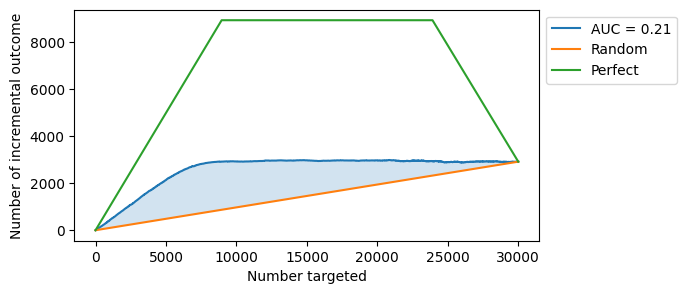

Qini Score = 0.2057


In [26]:
basic_solomodel(data_3, 'other_ads')

In [27]:
def sklift_solomodel(data, channel):
    columns_to_exclude = [
        'user_id', 'campaing_id', 'delivery_date', 'channel', 
        'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city'
    ]
    filtered_data = data[data['channel'] == channel].drop(columns=columns_to_exclude)
    train_idx, test_idx = train_test_split(filtered_data.index, test_size=0.25, random_state=1337)
    X_train = filtered_data.loc[train_idx].drop(columns=['purchased'])
    y_train = filtered_data.loc[train_idx]['purchased']
    X_test = filtered_data.loc[test_idx].drop(columns=['purchased'])
    y_test = filtered_data.loc[test_idx]['purchased']
    logistic_model = LogisticRegression(random_state=1337)
    solo_model = SoloModel(estimator=logistic_model)
    solo_model.fit(
        X_train.drop(columns='t_flag'),  
        y_train,                       
        treatment=X_train['t_flag']    
    )
    uplift_predictions = solo_model.predict(X_test.drop(columns='t_flag'))
    uplift_df = pd.DataFrame(uplift_predictions, index=X_test.index, columns=['uplift'])
    uplift_df = uplift_df.sort_values(by='uplift', ascending=False)
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data=uplift_df, x='uplift').set_title('Uplift Distribution')
    plt.show()

    qini_score = qini_auc_score(
        y_true=y_test,
        uplift=pd.Series(uplift_predictions, index=X_test.index),
        treatment=X_test['t_flag']
    )
    

    qini_plot = plot_qini_curve(
        y_true=y_test,
        uplift=pd.Series(uplift_predictions, index=X_test.index),
        treatment=X_test['t_flag']
    )
    qini_plot.figure_.set_size_inches(6, 3)
    plt.show()
    
    print(f'Qini Score: {qini_score:.4f}')

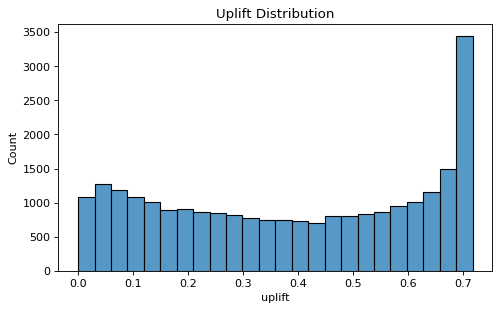

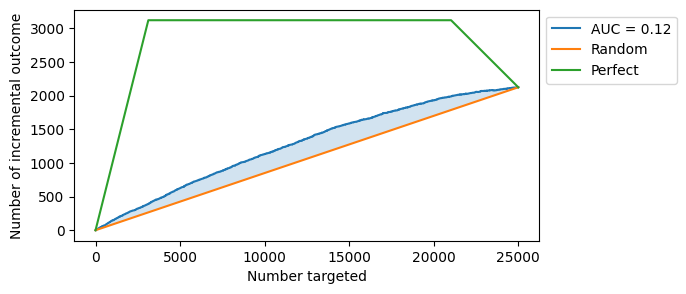

Qini Score: 0.1193


In [28]:
sklift_solomodel(data_3, 'push')

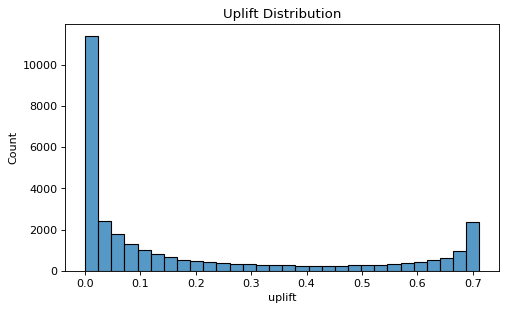

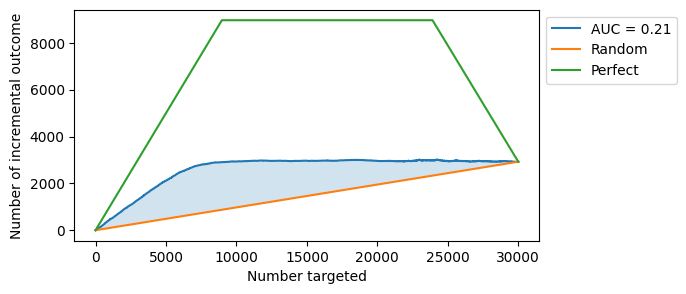

Qini Score: 0.2059


In [29]:
sklift_solomodel(data_3, 'banner')

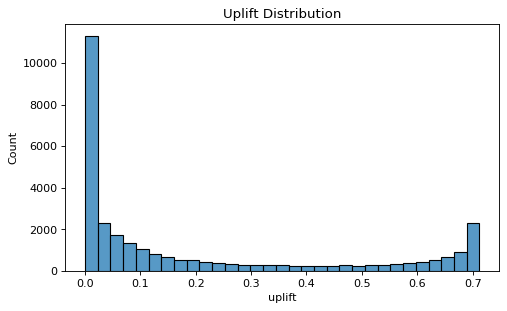

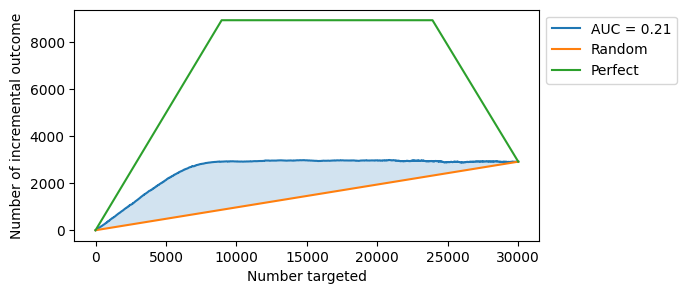

Qini Score: 0.2057


In [30]:
sklift_solomodel(data_3, 'other_ads')

In [32]:
def calibrated(data, channel):
    columns_to_drop = [
        'user_id', 'campaing_id', 'delivery_date', 'channel', 
        'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city'
    ]
    df_uplift = data[data['channel'] == channel].drop(columns=columns_to_drop)
    train_idx, test_idx = train_test_split(df_uplift.index, test_size=0.25, random_state=1337)
    X_train = df_uplift.loc[train_idx].drop(columns=['purchased'])
    y_train = df_uplift.loc[train_idx]['purchased']
    X_test = df_uplift.loc[test_idx].drop(columns=['purchased'])
    y_test = df_uplift.loc[test_idx]['purchased']
    skf = StratifiedKFold(n_splits=5, random_state=1337, shuffle=True)
    model_1_cb = CatBoostClassifier(verbose=0, random_seed=1337, thread_count=-1)
    model_2_cb = CatBoostClassifier(verbose=0, random_seed=1337+1, thread_count=-1)
    calib_model_1 = CalibratedClassifierCV(estimator=model_1_cb, method='isotonic', cv=skf)
    calib_model_2 = CalibratedClassifierCV(estimator=model_2_cb, method='isotonic', cv=skf)

    tm_catboost = TwoModels(estimator_trmnt=calib_model_1, estimator_ctrl=calib_model_2)
    tm_catboost.fit(
        X_train.drop(columns='t_flag'),  
        y_train,                        
        treatment=X_train['t_flag']     
    )


    uplift_predictions = tm_catboost.predict(X_test.drop(columns='t_flag'))
    uplift_df = pd.DataFrame(uplift_predictions, index=X_test.index, columns=['uplift'])
    uplift_df = uplift_df.sort_values(by='uplift', ascending=False)
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data=uplift_df, x='uplift').set_title('Uplift Distribution')
    plt.show()
   
    qini_score = qini_auc_score(
        y_true=y_test,
        uplift=pd.Series(uplift_predictions, index=X_test.index),
        treatment=X_test['t_flag']
    )
    
    qini_plot = plot_qini_curve(
        y_true=y_test,
        uplift=pd.Series(uplift_predictions, index=X_test.index),
        treatment=X_test['t_flag']
    )
    qini_plot.figure_.set_size_inches(6, 3)
    plt.show()
    
    print(f'Qini Score: {qini_score:.4f}')

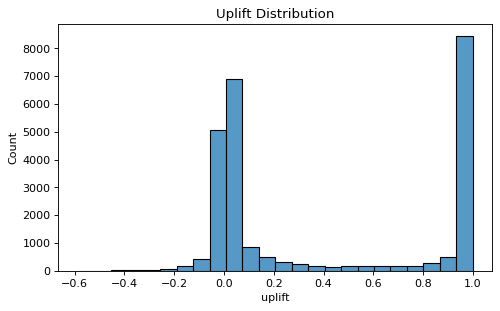

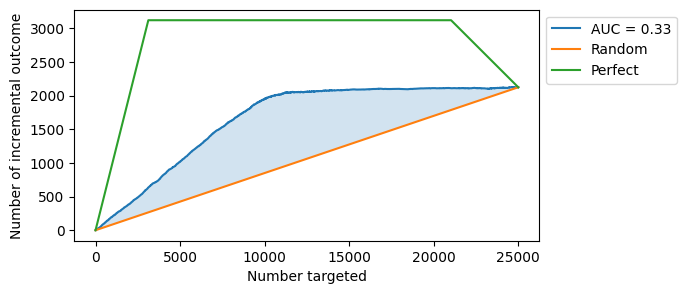

Qini Score: 0.3332


In [33]:
calibrated(data_3, 'push')

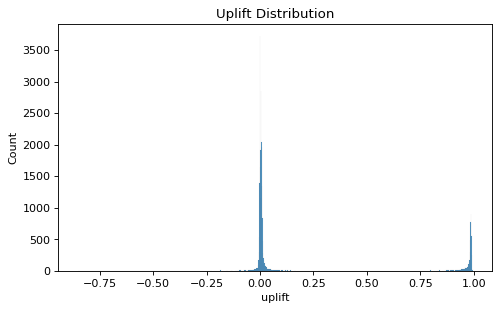

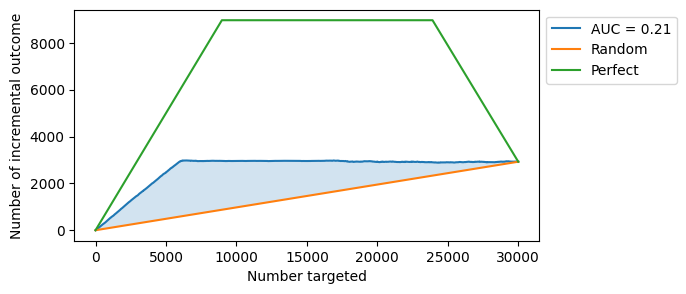

Qini Score: 0.2137


In [34]:
calibrated(data_3, 'banner')

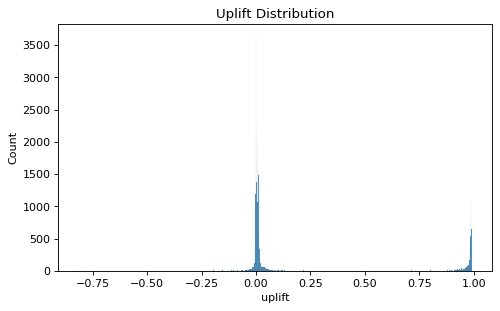

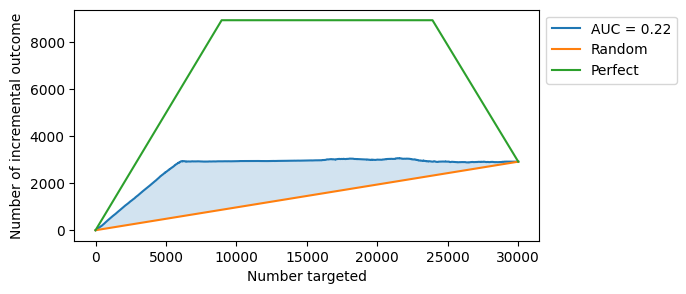

Qini Score: 0.2174


In [35]:
calibrated(data_3, 'other_ads')

In [36]:
def class_transform(data, channel):
    df = data[data['channel'] == channel].drop(
        columns=['user_id', 'campaing_id', 'delivery_date', 'channel', 
                 'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city']
    )
    
    train_idx, test_idx = train_test_split(df.index, test_size=0.25, random_state=1337)
    
    X_tr = df.loc[train_idx].drop(columns=['purchased'])
    y_tr = df.loc[train_idx]['purchased']
    X_te = df.loc[test_idx].drop(columns=['purchased'])
    y_te = df.loc[test_idx]['purchased']

    skf = StratifiedKFold(n_splits=5, random_state=1337, shuffle=True)
    cb = CatBoostClassifier(verbose=0, random_seed=1337, thread_count=-1)

    ct = ClassTransformation(cb)
    ct.fit(X_tr.drop(columns='t_flag'), y_tr, treatment=X_tr['t_flag'])

    uplift = ct.predict(X_te.drop(columns='t_flag'))

    uplift_df = pd.DataFrame(uplift, index=X_te.index, columns=['uplift'])
    uplift_df = uplift_df.sort_values(by='uplift', ascending=False)
    
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data=uplift_df, x='uplift').set_title('uplift')
    plt.show()
    
    qini = qini_auc_score(
        y_true=y_te,
        uplift=pd.Series(uplift, index=X_te.index),
        treatment=X_te['t_flag']
    )
    
    fig = plot_qini_curve(
        y_true=y_te,
        uplift=pd.Series(uplift, index=X_te.index),
        treatment=X_te['t_flag']
    )
    fig.figure_.set_size_inches(6, 3)
    plt.show()
    
    print(f'qini score = {qini:.4f}')

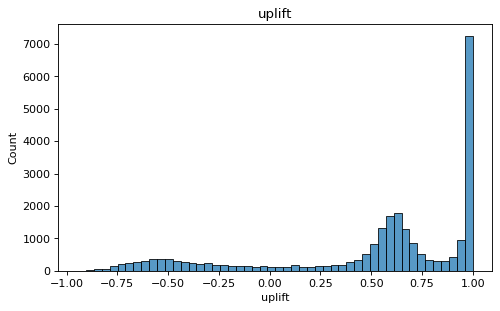

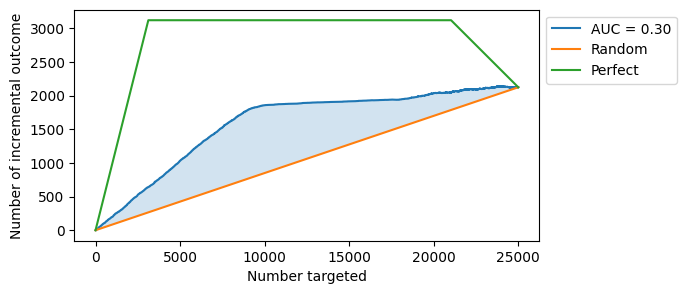

qini score = 0.2962


In [37]:
class_transform(data_3, 'push')

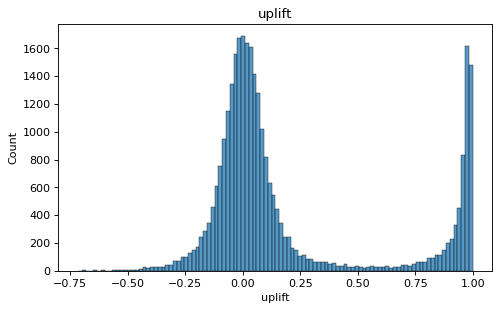

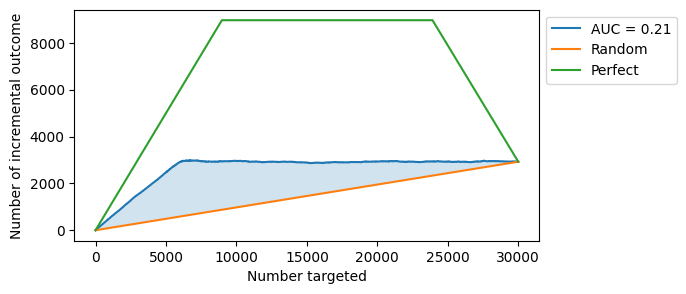

qini score = 0.2123


In [38]:
class_transform(data_3, 'banner')

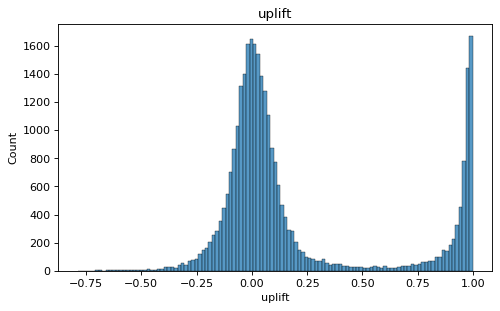

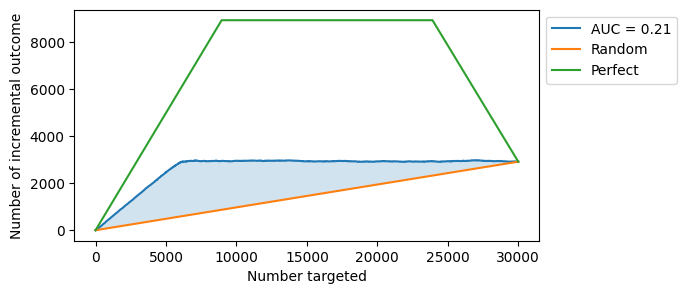

qini score = 0.2148


In [39]:
class_transform(data_3, 'other_ads')

In [43]:
from causalml.inference.tree import UpliftRandomForestClassifier
def random_forest(data, channel):
    df = data[data['channel'] == channel].drop(
        columns=['user_id', 'campaing_id', 'delivery_date', 'channel', 
                 'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city']
    )
    
    train_idx, test_idx = train_test_split(df.index, test_size=0.25, random_state=1337)
    
    X_tr = df.loc[train_idx].drop(columns=['purchased'])
    y_tr = df.loc[train_idx]['purchased']
    X_te = df.loc[test_idx].drop(columns=['purchased'])
    y_te = df.loc[test_idx]['purchased']
    
    rf = UpliftRandomForestClassifier(control_name='0', random_state=1337)
    
    X_tr['t_flag'] = X_tr['t_flag'].astype('str')
    X_te['t_flag'] = X_te['t_flag'].astype('str')
    
    rf.fit(
        X=X_tr.drop(columns='t_flag').values,
        y=y_tr.values,
        treatment=X_tr['t_flag'].values
    )
    
    uplift = rf.predict(X=X_te.drop(columns='t_flag').values).flatten()

    uplift_df = pd.DataFrame(uplift, index=X_te.index, columns=['uplift'])
    uplift_df = uplift_df.sort_values(by='uplift', ascending=False)
    
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data=uplift_df, x='uplift').set_title('uplift')
    plt.show()
    
    qini = qini_auc_score(
        y_true=y_te,
        uplift=uplift,
        treatment=X_te['t_flag'].astype('int')
    )
    
    fig = plot_qini_curve(
        y_true=y_te,
        uplift=uplift,
        treatment=X_te['t_flag'].astype('int')
    )
    fig.figure_.set_size_inches(6, 3)
    plt.show()
    
    print(f'qini score = {qini:.4f}')

ModuleNotFoundError: No module named 'causalml'

In [41]:
random_forest(data_3, 'push')

NameError: name 'UpliftRandomForestClassifier' is not defined

In [ ]:
random_forest(data_3, 'banner')

In [ ]:
random_forest(data_3, 'other_ads')

In [ ]:
def sklift_solomodel_scaler(data, channel):
    df_uplift = data.query(f''' channel == '{channel}' ''').drop(
    columns=['user_id', 'campaing_id', 'delivery_date', 'channel', 'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city']
    )
    train_index, test_index = train_test_split(df_uplift.index, test_size=0.25, random_state=1337)
    X_train = df_uplift.loc[train_index].drop(columns = ['purchased'])
    y_train = df_uplift.loc[train_index]['purchased']
    X_test = df_uplift.loc[test_index].drop(columns = ['purchased'])
    y_test = df_uplift.loc[test_index]['purchased']

    model = LogisticRegression(random_state=1337)
    sm = SoloModel(estimator=model)
    
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', sm)
    ])
    pipe.fit(X_train.drop(columns='t_flag'),
       y_train,
       model_uplift__treatment=X_train['t_flag'])

    uplift = pipe.predict(X_test.drop(columns='t_flag'))

    uplift_pd = pd.DataFrame(data = uplift, index = X_test.index, columns=['uplift'])
    uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
    
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data = uplift_pd, x=uplift).set_title('uplift')
    plt.show()
    
    qini_score = qini_auc_score(y_true=y_test,
                   uplift=pd.Series(uplift, index=X_test.index),
                   treatment=X_test['t_flag'])
    
    fig = plot_qini_curve(y_true=y_test,
                      uplift=pd.Series(uplift, index=X_test.index),
                      treatment=X_test['t_flag'])
    fig.figure_.set_size_inches(6, 3)
    plt.show()
    
    print(f'qini score = {qini_score}')

ImportError: cannot import name 'validate_data' from 'sklearn.utils.validation' (c:\Users\User\miniconda3\lib\site-packages\sklearn\utils\validation.py)

In [47]:
def sklift_solomodel_scaler(data, channel):
    df = data[data['channel'] == channel].drop(
        columns=['user_id', 'campaing_id', 'delivery_date', 'channel', 
                 'report_dt_x', 'report_m', 'report_dt_y', 'x5', 'city']
    )
    
    train_idx, test_idx = train_test_split(df.index, test_size=0.25, random_state=1337)
    
    X_tr = df.loc[train_idx].drop(columns=['purchased'])
    y_tr = df.loc[train_idx]['purchased']
    X_te = df.loc[test_idx].drop(columns=['purchased'])
    y_te = df.loc[test_idx]['purchased']

    model = LogisticRegression(random_state=1337)
    sm = SoloModel(estimator=model)
    
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', sm)
    ])
    
    pipe.fit(
        X_tr.drop(columns='t_flag'),
        y_tr,
        model_uplift__treatment=X_tr['t_flag']
    )

    uplift = pipe.predict(X_te.drop(columns='t_flag'))

    uplift_df = pd.DataFrame(uplift, index=X_te.index, columns=['uplift'])
    uplift_df = uplift_df.sort_values(by='uplift', ascending=False)
    
    plt.figure(figsize=(7, 4), dpi=80)
    sns.histplot(data=uplift_df, x='uplift').set_title('uplift')
    plt.show()
    
    qini = qini_auc_score(
        y_true=y_te,
        uplift=pd.Series(uplift, index=X_te.index),
        treatment=X_te['t_flag']
    )
    
    fig = plot_qini_curve(
        y_true=y_te,
        uplift=pd.Series(uplift, index=X_te.index),
        treatment=X_te['t_flag']
    )
    fig.figure_.set_size_inches(6, 3)
    plt.show()
    
    print(f'qini score = {qini:.4f}')

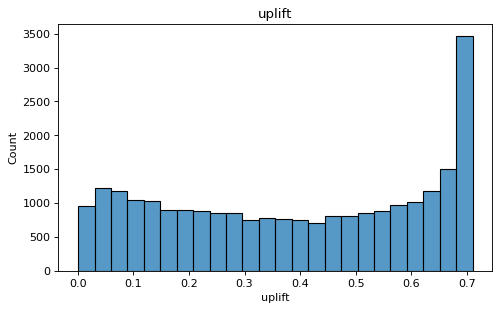

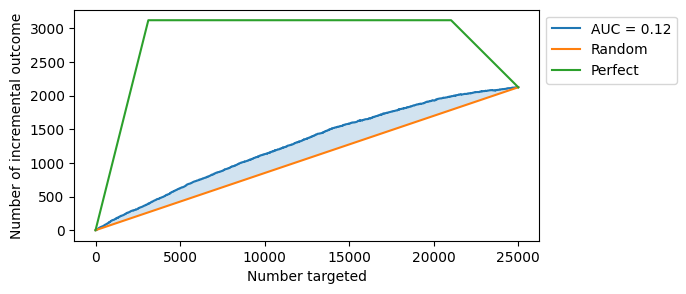

qini score = 0.1187


In [48]:
sklift_solomodel_scaler(data_3, 'push')

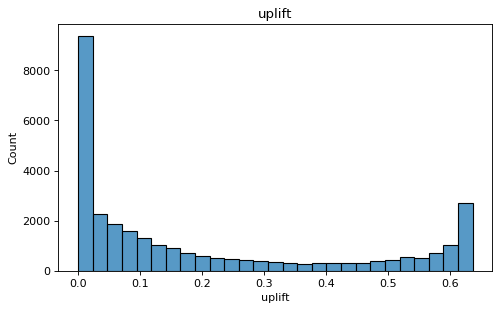

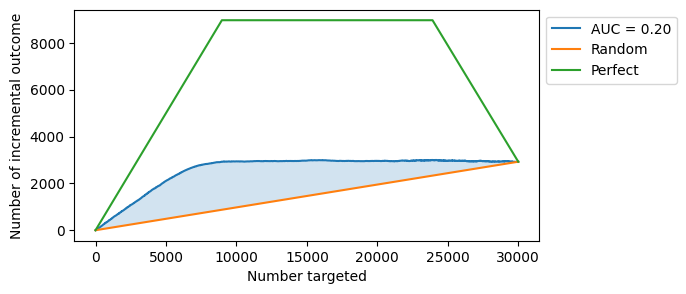

qini score = 0.2048


In [49]:
sklift_solomodel_scaler(data_3, 'banner')

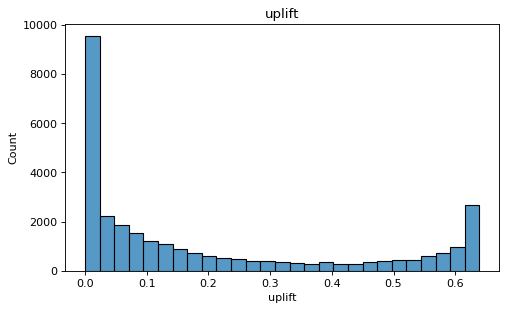

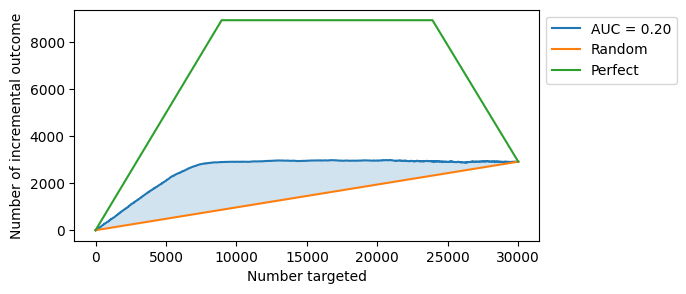

qini score = 0.2044


In [50]:
sklift_solomodel_scaler(data_3, 'other_ads')

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

### ваши выводы здесь